In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path('Yen_csv.csv'), index_col = 'Date', infer_datetime_format = True, parse_dates = True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2,1
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0,1
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0,1
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0,1
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0,1


In [3]:
# Trim dataset to start on January 1st, 1990
yen_futures = yen_futures.loc['1990-01-01':, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336,51473
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206,53860
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649,55699
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944,53111
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763,52072


# Return Forecasting: Initial Time-Series Plotting
---

<AxesSubplot:xlabel='Date'>

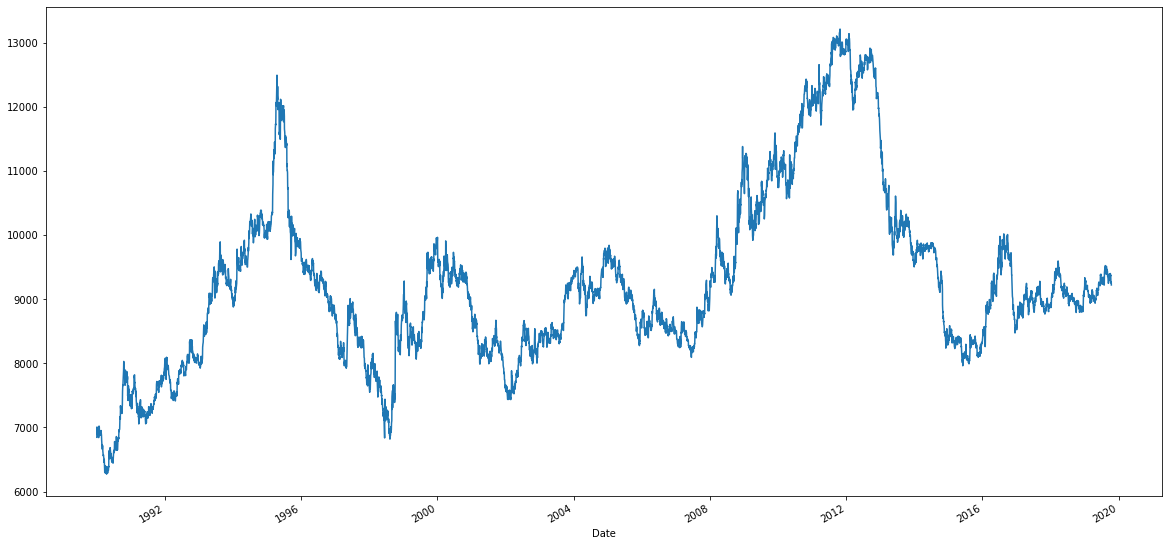

In [4]:
# Plot the "Settle" column
yen_futures.Settle.plot(figsize = (20,10))

# Decomposition Using a Hodrick-Prescott Filter
---

In [5]:
import statsmodels.api as sm
yen_noise, yen_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [6]:
# Create a dataframe of just the settle price and add noise and trend columns 
yen_df = yen_futures[['Settle']]
yen_df['noise'] = yen_noise
yen_df['trend'] = yen_trend
yen_df.head()

<ipython-input-6-4e9433168704>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yen_df['noise'] = yen_noise
<ipython-input-6-4e9433168704>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yen_df['trend'] = yen_trend


,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


<AxesSubplot:title={'center':'Settle VS Trend'}, xlabel='Date'>

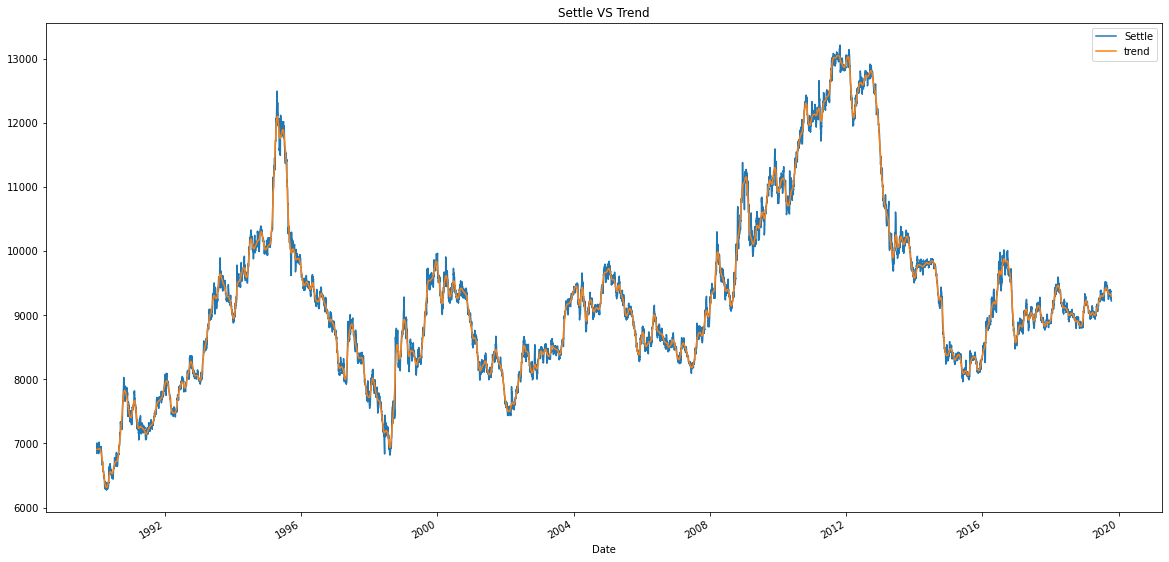

In [7]:
# Plot the Settle Price vs. the Trend for 2015 to present
yen_df.plot(y = ['Settle','trend'], figsize = (20,10), title = 'Settle VS Trend')

<AxesSubplot:xlabel='Date'>

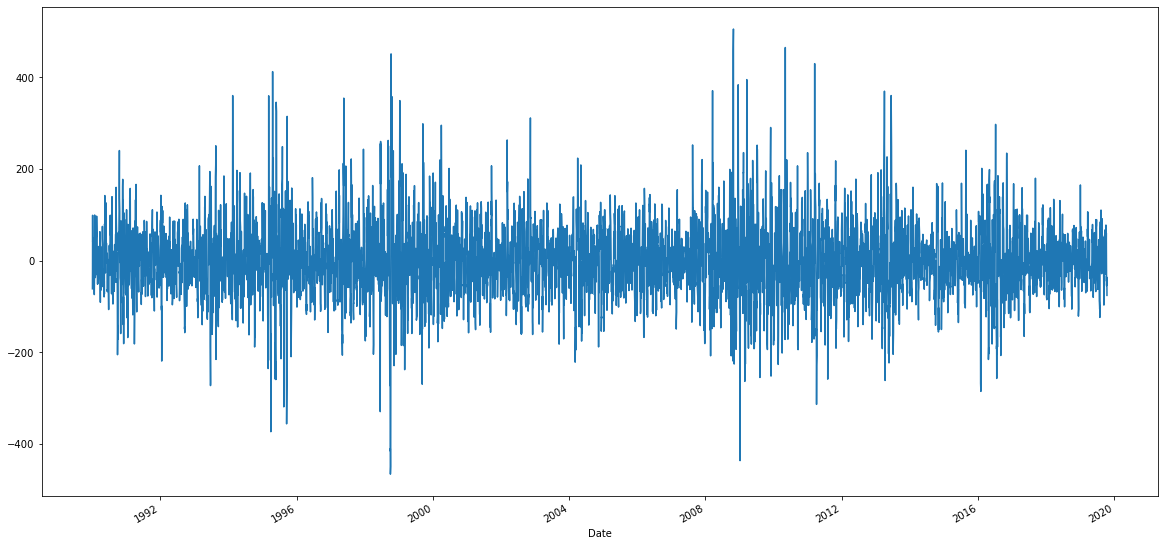

In [8]:
# Plot Settle noise
yen_noise.plot(figsize = (20,10))

# Forecasting Returns using an ARMA Model
---

In [9]:
# Create series using Settle price percentage returns, drop NaNs
returns = (yen_futures[['Settle']].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [16]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model
model = ARMA(returns.values, order = (2,1))

# Fit model
results = model.fit()

C:\Users\javie\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [18]:
# Output results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Sat, 03 Jul 2021   AIC                          15798.142
Time:                        17:48:22   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3062      1.277     -0.240      0.811      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2946      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3352           +0.0000j            3.3352            0.5000
AR.2         -157.2096           +0.0000j          157.2096            0.5000
MA.1           -3.3941           +0.0000j            3.3941            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

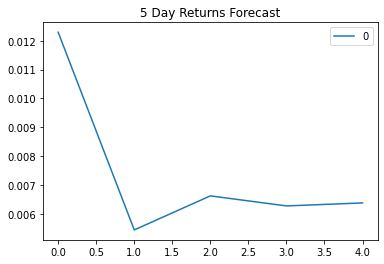

In [20]:
# Plot 5 day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

## Forecasting the Settle Price using an ARIMA Model

In [22]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
model_2 = ARIMA(yen_df['Settle'], order =(5,1,1))

# Fit the model
results_2 = model_2.fit()

C:\Users\javie\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\javie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

In [24]:
# Output summary results 
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Sat, 03 Jul 2021   AIC                          83905.238
Time:                        18:02:33   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.Settle     0.2821      0.699      0.403      0.687      -1.088       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2972      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8917           -1.3787j            2.3408           -0.1002
AR.2            1.8917           +1.3787j            2.3408            0.1002
AR.3           -2.2698           -3.0207j            3.7785           -0.3526
AR.4           -2.2698           +3.0207j            3.7785            0.3526
AR.5          -11.0610           -0.0000j           11.0610           -0.5000
MA.1            3.3652           +0.0000j            3.3652            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}>

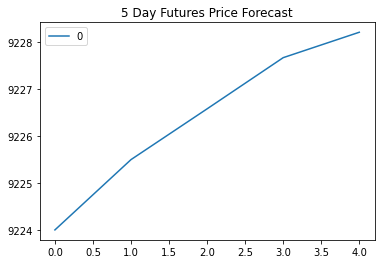

In [25]:
# Plot 5 day price forecast
pd.DataFrame(results_2.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

## Volatility Forecasting with GARCH

In [27]:
from arch import arch_model

# Estimate using GARCH model
model_3 = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
results_3 = model_3.fit(disp = 'off')

In [29]:
# Summarize results
results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Sat, Jul 03 2021   Df Residuals:                     7514
Time:                        18:10:46   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [30]:
# Find last day of dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [32]:
# Create 5 day forecast of volatility 
forecast_horizon = 5

forecasts = results_3.forecast(start='2019-10-15', horizon=forecast_horizon)
forecasts

C:\Users\javie\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [33]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [34]:
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


<AxesSubplot:>

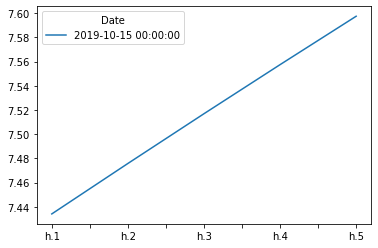

In [35]:
final.plot()

## Conclusions 